# Predecir si el ejercicio es correcto
Aplicar Machine Learning para predecir si el paciente está realizando correctamente el ejercicio (clasificación binaria)

In [25]:
# ---------- importar librerías---------
# Manipular los datos
import pandas as pd

# Gráficas
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
sns.set_theme(style="darkgrid")

# scikit-learn (ML en python)
## Procesar el dataset
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
## Modelos ML
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
## Evaluación de los modelos
from sklearn.metrics import *
from sklearn.model_selection import cross_val_score
## Hiperparametrizacion
from sklearn.model_selection import GridSearchCV
## Seleccion de variables
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_selection import RFECV # recursive

# Class imbalance
from imblearn.under_sampling import NearMiss, EditedNearestNeighbours
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTETomek, SMOTEENN
from collections import Counter


# Para ignorar los FutureWarning
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)

In [26]:
#---------Importar los datos-----------
# Dataframe medidas calculadas por repetición
df = pd.read_csv('../csvFiles/medidasPerRepetition.csv', dtype=object)

In [27]:
# ------Preparar el dataset-------
encoder = OrdinalEncoder(categories=[list(set(df["Position"].values))])
encoder.fit(df[["Position"]])
df["Position"] = encoder.transform(df[["Position"]])

# pasar variable obj to numeric
df = df.apply(pd.to_numeric, errors='ignore')

# cmabiar las poorly executed to incorrectly executed
df[df['CorrectLabel']==3] = 2

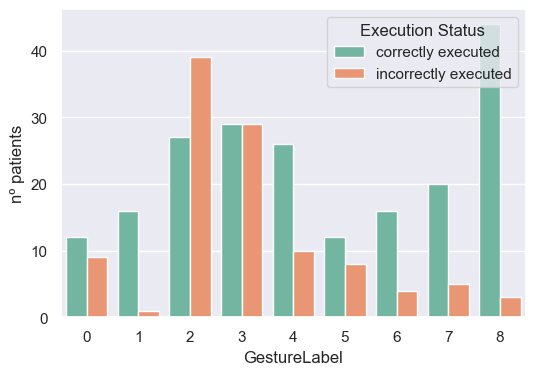

In [28]:
#---------Distribución de las clases--------
plt.figure(figsize=(6,4))
sns.countplot(x="GestureLabel", hue="CorrectLabel",  data=df, palette = "Set2")
plt.legend(title='Execution Status', labels=["correctly executed", "incorrectly executed"])
plt.ylabel('nº patients')
plt.show()

In [29]:
#-------Funciones--------

# Para entrenat los modelos de ML
def aplicar_modelos( X:pd.DataFrame, y:pd.DataFrame, tX:pd.DataFrame, ty:pd.DataFrame):
   """
   Aplica una lista de modelos de aprendizaje automático a los datos de prueba y muestra
   los informes de evaluación.

   Parámetros:
   * X: datos de entrenamiento.
   * y: target de entrenamiento.
   * tX: datos de prueba.
   * ty: target de prueba.
   """
   # creación de los modelos
   knn = KNeighborsClassifier(n_neighbors=1) # K-Neighbors classifier
   dtree = DecisionTreeClassifier() # Decision tree
   nb = GaussianNB() # Naive Bayes
   svm = SVC() # Suport Vector Machine
   rf = RandomForestClassifier(n_estimators = 5)  # Random Forest
   lr = LogisticRegression(max_iter = 500) # ¿o usar StandardScaler?

   models = [knn, dtree, nb, svm, rf, lr]
   
   # Iteramos sobre los modelos
   for modelo in models:
        try:
            scores = cross_val_score(modelo, X, y, cv=5)
            print(f"\nModelo: {modelo.__class__.__name__}") 
            print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))
        except ValueError as e:
            print(f"Skipping {modelo.__class__.__name__} due to ERROR: {e}")

    
# Aplicar imbalance learn
def aplicar_imblearn(X,y, tX, ty):
   nm1 = NearMiss(version=1, n_neighbors=2)
   enn = EditedNearestNeighbours()
   adasyn = ADASYN(n_neighbors = 2)
   smote = SMOTE()
   smotetomek = SMOTETomek()
   smote_enn = SMOTEENN(random_state=0)

   imblearns = [nm1, enn, adasyn, smote, smotetomek, smote_enn]
   for imblearn in imblearns:
        try:
            X_train_im, y_train_im = imblearn.fit_resample(X, y)
            print(f"\n- MODELO DE RESAMPLING: {imblearn.__class__.__name__}") 
            print ("Distribution of class labels before resampling {}".format(Counter(y)))
            print ("Distribution of class labels after resampling {}".format(Counter(y_train_im)))
            aplicar_modelos(X_train_im, y_train_im, tX, ty)
        except ValueError as e:
                print(f"Skipping {imblearn.__class__.__name__} due to ERROR: {e}")
        except RuntimeError as e:
                print(f"Skipping {imblearn.__class__.__name__} due to ERROR: {e}")
           

In [32]:
gestures  = [0, 2, 3,4,5,6,7,8]#df['GestureLabel'].unique()

for gesture in gestures:

    df_gesture = df[df['GestureLabel']==gesture]

    #---------Dividimos el dataset------------
    #---------Dividimos en train y test------------
    df_train, df_test = train_test_split(df_gesture, test_size = 0.3, stratify=df_gesture['CorrectLabel'])

    # Dividimos el conjunto de train en varibales independientes y en target
    X_train = df_train.drop(['CorrectLabel'], axis = 1)
    y_train = pd.DataFrame(df_train['CorrectLabel'])

    # Dividimos el conjunto de test
    X_test = df_test.drop(['CorrectLabel'], axis = 1)
    y_test = pd.DataFrame(df_test['CorrectLabel'])

    # Convertimos los df de target (y) a 1-d
    y_train = y_train.values.ravel()
    y_test = y_test.values.ravel()
    
    print(f'\n------------ CLASIFICACIÓN GESTO {gesture} -----------')
    aplicar_imblearn(X_train, y_train, X_test, y_test)


------------CLASIFICACIÓN GESTO 0 -----------

- MODELO DE RESAMPLING: NearMiss
Distribution of class labels before resampling Counter({1: 8, 2: 6})
Distribution of class labels after resampling Counter({1: 6, 2: 6})

Modelo: KNeighborsClassifier
0.83 accuracy with a standard deviation of 0.21

Modelo: DecisionTreeClassifier
0.90 accuracy with a standard deviation of 0.20

Modelo: GaussianNB
0.77 accuracy with a standard deviation of 0.29

Modelo: SVC
0.90 accuracy with a standard deviation of 0.20

Modelo: RandomForestClassifier
1.00 accuracy with a standard deviation of 0.00

Modelo: LogisticRegression
0.83 accuracy with a standard deviation of 0.21

- MODELO DE RESAMPLING: EditedNearestNeighbours
Distribution of class labels before resampling Counter({1: 8, 2: 6})
Distribution of class labels after resampling Counter({1: 7, 2: 6})

Modelo: KNeighborsClassifier
0.90 accuracy with a standard deviation of 0.20

Modelo: DecisionTreeClassifier
1.00 accuracy with a standard deviation of 

C:\Users\nerea\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\nerea\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\nerea\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\nerea\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-


Modelo: SVC
0.90 accuracy with a standard deviation of 0.20

Modelo: RandomForestClassifier
0.90 accuracy with a standard deviation of 0.20

Modelo: LogisticRegression
0.90 accuracy with a standard deviation of 0.20

- MODELO DE RESAMPLING: ADASYN
Distribution of class labels before resampling Counter({1: 8, 2: 6})
Distribution of class labels after resampling Counter({1: 8, 2: 8})


C:\Users\nerea\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(



Modelo: KNeighborsClassifier
0.88 accuracy with a standard deviation of 0.15

Modelo: DecisionTreeClassifier
0.87 accuracy with a standard deviation of 0.27

Modelo: GaussianNB
0.87 accuracy with a standard deviation of 0.27

Modelo: SVC
0.87 accuracy with a standard deviation of 0.16

Modelo: RandomForestClassifier
0.80 accuracy with a standard deviation of 0.27

Modelo: LogisticRegression
0.77 accuracy with a standard deviation of 0.29

- MODELO DE RESAMPLING: SMOTE
Distribution of class labels before resampling Counter({1: 8, 2: 6})
Distribution of class labels after resampling Counter({1: 8, 2: 8})

Modelo: KNeighborsClassifier
0.88 accuracy with a standard deviation of 0.15

Modelo: DecisionTreeClassifier
0.82 accuracy with a standard deviation of 0.26

Modelo: GaussianNB
0.87 accuracy with a standard deviation of 0.27

Modelo: SVC
0.93 accuracy with a standard deviation of 0.13

Modelo: RandomForestClassifier
0.87 accuracy with a standard deviation of 0.27

Modelo: LogisticRegre

C:\Users\nerea\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\nerea\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\nerea\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\nerea\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-


Modelo: RandomForestClassifier
1.00 accuracy with a standard deviation of 0.00

Modelo: LogisticRegression
1.00 accuracy with a standard deviation of 0.00

------------CLASIFICACIÓN GESTO 6 -----------

- MODELO DE RESAMPLING: NearMiss
Distribution of class labels before resampling Counter({1: 11, 2: 3})
Distribution of class labels after resampling Counter({1: 3, 2: 3})
Skipping KNeighborsClassifier due to ERROR: n_splits=5 cannot be greater than the number of members in each class.
Skipping DecisionTreeClassifier due to ERROR: n_splits=5 cannot be greater than the number of members in each class.
Skipping GaussianNB due to ERROR: n_splits=5 cannot be greater than the number of members in each class.
Skipping SVC due to ERROR: n_splits=5 cannot be greater than the number of members in each class.
Skipping RandomForestClassifier due to ERROR: n_splits=5 cannot be greater than the number of members in each class.
Skipping LogisticRegression due to ERROR: n_splits=5 cannot be greater th

C:\Users\nerea\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\nerea\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\nerea\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\nerea\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-


Modelo: GaussianNB
0.93 accuracy with a standard deviation of 0.13

Modelo: SVC
0.87 accuracy with a standard deviation of 0.16

Modelo: RandomForestClassifier
0.93 accuracy with a standard deviation of 0.13

Modelo: LogisticRegression
1.00 accuracy with a standard deviation of 0.00
Skipping ADASYN due to ERROR: Not any neigbours belong to the majority class. This case will induce a NaN case with a division by zero. ADASYN is not suited for this specific dataset. Use SMOTE instead.


C:\Users\nerea\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\nerea\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\nerea\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Skipping SMOTE due to ERROR: Expected n_neighbors <= n_samples_fit, but n_neighbors = 6, n_samples_fit = 3, n_samples = 3
Skipping SMOTETomek due to ERROR: Expected n_neighbors <= n_samples_fit, but n_neighbors = 6, n_samples_fit = 3, n_samples = 3
Skipping SMOTEENN due to ERROR: Expected n_neighbors <= n_samples_fit, but n_neighbors = 6, n_samples_fit = 3, n_samples = 3

------------CLASIFICACIÓN GESTO 7 -----------

- MODELO DE RESAMPLING: NearMiss
Distribution of class labels before resampling Counter({1: 14, 2: 3})
Distribution of class labels after resampling Counter({1: 3, 2: 3})
Skipping KNeighborsClassifier due to ERROR: n_splits=5 cannot be greater than the number of members in each class.
Skipping DecisionTreeClassifier due to ERROR: n_splits=5 cannot be greater than the number of members in each class.
Skipping GaussianNB due to ERROR: n_splits=5 cannot be greater than the number of members in each class.
Skipping SVC due to ERROR: n_splits=5 cannot be greater than the numbe

C:\Users\nerea\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\nerea\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\nerea\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\nerea\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-


Modelo: SVC
0.73 accuracy with a standard deviation of 0.23

Modelo: RandomForestClassifier
1.00 accuracy with a standard deviation of 0.00


C:\Users\nerea\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(



Modelo: LogisticRegression
1.00 accuracy with a standard deviation of 0.00

- MODELO DE RESAMPLING: ADASYN
Distribution of class labels before resampling Counter({1: 14, 2: 3})
Distribution of class labels after resampling Counter({1: 14, 2: 13})

Modelo: KNeighborsClassifier
0.89 accuracy with a standard deviation of 0.09

Modelo: DecisionTreeClassifier
0.96 accuracy with a standard deviation of 0.08

Modelo: GaussianNB
1.00 accuracy with a standard deviation of 0.00

Modelo: SVC
0.81 accuracy with a standard deviation of 0.17

Modelo: RandomForestClassifier
0.85 accuracy with a standard deviation of 0.15

Modelo: LogisticRegression
0.93 accuracy with a standard deviation of 0.09
Skipping SMOTE due to ERROR: Expected n_neighbors <= n_samples_fit, but n_neighbors = 6, n_samples_fit = 3, n_samples = 3
Skipping SMOTETomek due to ERROR: Expected n_neighbors <= n_samples_fit, but n_neighbors = 6, n_samples_fit = 3, n_samples = 3
Skipping SMOTEENN due to ERROR: Expected n_neighbors <= n_sa

C:\Users\nerea\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\nerea\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\nerea\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\nerea\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-


Modelo: KNeighborsClassifier
0.94 accuracy with a standard deviation of 0.08

Modelo: DecisionTreeClassifier
0.90 accuracy with a standard deviation of 0.13

Modelo: GaussianNB
0.94 accuracy with a standard deviation of 0.08

Modelo: SVC
0.94 accuracy with a standard deviation of 0.08

Modelo: RandomForestClassifier
0.94 accuracy with a standard deviation of 0.08

Modelo: LogisticRegression
0.94 accuracy with a standard deviation of 0.08
Skipping ADASYN due to ERROR: Expected n_neighbors <= n_samples_fit, but n_neighbors = 3, n_samples_fit = 2, n_samples = 2
Skipping SMOTE due to ERROR: Expected n_neighbors <= n_samples_fit, but n_neighbors = 6, n_samples_fit = 2, n_samples = 2
Skipping SMOTETomek due to ERROR: Expected n_neighbors <= n_samples_fit, but n_neighbors = 6, n_samples_fit = 2, n_samples = 2
Skipping SMOTEENN due to ERROR: Expected n_neighbors <= n_samples_fit, but n_neighbors = 6, n_samples_fit = 2, n_samples = 2


C:\Users\nerea\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\nerea\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
